In [64]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
#from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *
from sklearn.decomposition import PCA
from scipy.stats.mstats import zscore # This is to standardized the parameters

%matplotlib inline
np.random.seed(1)

## 1. Load Data

In [65]:
# import pickle
# fpath="Datasets\Data_M_2.8_R_0.5_S_4_Sec_256_2D_129_45.pkl"
# pkl_file = open(fpath, 'rb')
# data = pickle.load(pkl_file)
# label="Datasets\Label_M_2.8_R_0.5_S_4_Sec_256.npy"
# label=np.load(label)
# print(data.shape)
# print(label.shape)

#events = np.load("Datasets\DataDetection_M_2.8_R_0.5_S_4_Sec_256.npy")
#label = np.load("Datasets\LabelDetection_M_2.8_R_0.5_S_4_Sec_256.npy")
#times = np.load("Datasets/TimeDetection_M_2.8_R_0.5_S_4_Sec_256.npy") # features, # samples


events = np.load("Datasets/DataTest_M_3_R_0.12_S_5_Sec_60.npy")
label = np.load("Datasets/LabelTest_M_3_R_0.12_S_5_Sec_60.npy")
times = np.load("Datasets/TimeTest_M_3_R_0.12_S_5_Sec_60.npy")

print(events.shape)
times = (times - times[0,:]) * 3600 * 24 # set time to 0 and in seconds
fs = (times[:,0] < 60).nonzero()[0].shape[0] / 60 # sampling frequency

print(fs)
#fs=1
from scipy.signal import spectrogram

_, _, Sxx = spectrogram(events[:,0,1], fs)
spectrogram_shape = Sxx.shape
print(spectrogram_shape)



(2400, 20, 3)
40.0
(129, 10)


In [66]:
times.shape
fs

40.0

In [67]:
data = np.zeros((events.shape[1], spectrogram_shape[0], spectrogram_shape[1],3))
print(data.shape)
for k in range(3):
    for i in range(events.shape[1]):
        _, _, Sxx = spectrogram(events[:,i,k], fs)
        #print(Sxx.shape)
        data[i, :, :,k] = np.log10(Sxx)

#data = data[:,:,:,np.newaxis] 

(20, 129, 10, 3)


In [68]:
def split_reshape_dataset(X, Y, ratio):
    #X = X.T[:,:,np.newaxis, np.newaxis]
    #Y = Y.T
    m = X.shape[0] # number of samples
    sortInd = np.arange(m)
    np.random.shuffle(sortInd)
    nTrain = int(ratio * m)
    X_train = X[sortInd[:nTrain], :, :, :]
    Y_train = Y[sortInd[:nTrain],:]
    X_test = X[sortInd[nTrain:], :, :, :]
    Y_test = Y[sortInd[nTrain:],:]
    return X_train, X_test, Y_train, Y_test

#data = data[300:700,:]
#data = (data - np.mean(data, axis = 0, keepdims= True)) / np.std(data, axis = 0, keepdims = True)
data=zscore(data)
RatioTraining=0.8; # 0.8 before
X_train, X_test, Y_train, Y_test = split_reshape_dataset(data, label, RatioTraining)
Y_train =convert_to_one_hot(Y_train,2).T
Y_test = convert_to_one_hot(Y_test,2).T

print(X_train.shape)
print(Y_train.shape)
print(data.shape)
print(label.shape)
i = 104

(16, 129, 10, 3)
(16, 2)
(20, 129, 10, 3)
(20, 1)


## 2. TensorFlow Functions

In [69]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(tf.float32,shape=(None, n_H0, n_W0, n_C0))#None
    Y = tf.placeholder(tf.float32,shape=(None,n_y))#None
    
    return X, Y

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
    filtersize1=4; # originally 4
    filtersize2=2; # originally 2
    NumFilters1=8; #4
    NumFilters2=16; #8
    W1 = tf.get_variable("W1", [16, 4, 3, NumFilters1], initializer = tf.contrib.layers.xavier_initializer(seed = 0))#None
    W2 = tf.get_variable("W2", [8, 2, NumFilters1, NumFilters2], initializer = tf.contrib.layers.xavier_initializer(seed = 0))#None
    
#    W1 = tf.get_variable("W1", [filtersize1, 1, 1, NumFilters1], initializer = tf.contrib.layers.xavier_initializer(seed = 0))#None
#    W2 = tf.get_variable("W2", [filtersize2, 1, NumFilters1, NumFilters2], initializer = tf.contrib.layers.xavier_initializer(seed = 0))#None

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')#None
    # RELU
    A1 = tf.nn.relu(Z1)#None
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
#    P1 = tf.nn.max_pool(A1, ksize = [1,128,1,1], strides = [1,1,1,1], padding = 'SAME')#None
    P1 = tf.nn.max_pool(A1, ksize = [1,16,4,1], strides = [1,1,1,1], padding = 'SAME')#None
#    P1 = tf.nn.max_pool(A1, ksize = [1,4,4,1], strides = [1,1,1,1], padding = 'SAME')#None

    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')#None
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
#    P2 = tf.nn.max_pool(A2, ksize = [1,64,1,1], strides = [1,1,1,1], padding = 'SAME')#None
    P2 = tf.nn.max_pool(A2, ksize = [1,8,2,1], strides = [1,1,1,1], padding = 'SAME')#None

# FLATTEN
    P2 = tf.contrib.layers.flatten(P2)#None
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs=2,activation_fn=None)
    
    return Z3, W1, W2

def compute_cost(Z3, Y, W1, W2, beta):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    m = int(Y.get_shape()[1])
    cost = tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z3, labels = Y) 
    regularizer = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)
    #egularizer = sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
    cost = tf.reduce_mean(cost + 1/m* beta * regularizer)
    ### END CODE HERE ###
    
    return cost

In [70]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 10, minibatch_size = 50, print_cost = True, beta = 0.1):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)#None
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()#None
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3, W1, W2 = forward_propagation(X, parameters)#None
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y, W1, W2, beta)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)#None
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            #print(Y_train.shape)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})#None
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
         
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 3.523097
Cost after epoch 5: 0.750062
Cost after epoch 10: 0.434050
Cost after epoch 15: 0.321634
Cost after epoch 20: 0.308107
Cost after epoch 25: 0.294256


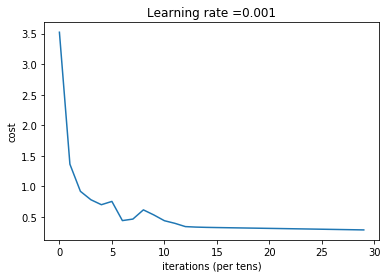

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 0.5


In [73]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test, num_epochs =30, learning_rate = 0.001, beta = .1,minibatch_size=1)

In [72]:
sum(label)/label.shape[0]

array([0.55])